Today in this lesson, we will learn the basics of Natural Language Processing(NLP) by building a model on "Sarcasm Detection".<br><br>
![sarcasm](https://distilledai.com/wp-content/uploads/2020/04/sarcasm.png)

We will use LSTM (Long Short Term Memory) layers to create our deep learning model who can predict whether a statement is sarcastic or not.<br><br>

But before going to start the coding part of the lesson, let's first understand basics of few things that we are going to use.<br>

## Tokenize
In NLP, we work with text data.<br>
But, machines / computers can't read text. They just deal with numbers.<br>
So, to convert text data into numbers, we give a unique ID number to each word & replace word it's corresponding number.
### That's what Tokenizer does.
It converts our text data to numeric format.<br>
Like, sentence `"machine learning is cool"` will convert into something like `"2315 834 12 4510"`.<br><br>

After converting our text data into numbers, now, we can use that data to train our ML models.<br>
But, there's one thing we are missing.<br><br>

After converting, each word into numbers, `king` word will converted into something like 1678, `queen` to something like 56832, `man` to something like 4285, `woman` to something like 6387 etc. (These numbers I have choosen randomly. Point being, it'll converted to numbers).<br>

* How, we will give our model information like, `king` & `queen` are related same as `man` & `woman`.<br>
* Or, `italy`, `spain`, `brazil`, `india`, `japan` etc. words have one thing in common. (They all are name of countris)<br>
* Or, `cricket`, `football`, `tennis` etc. words are also similar. (names of games)<br>
* Or, the way words `china` & `beijing` are related, words `russia` & `moscow` are also related in the same way.<br><br>

All these are knowledge related things.<br>
How can we give this knowledge to our NLP models so that, it can use that knowledge to perform better at detecting sarcasm?<br>

Answer is `word embeddings`.

## Word embeddings

Word embeddings are nothing but 1D vector of length 200-500, containing floating point numbers.<br>
Each word have corresponding 1D array for it.<br><br>

For e.g.<br>
`king` : `[-0.34, 0.98, -0.04, 0.32]`<br>
`queen` : `[0.25, -0.23, -0.10, -0.72]`<br>
.<br>
.<br>
.<br>

Here it's just 4 numbers in a 1D vector, but in actual there will be 200-500 numbers in a 1D vector for each word.<br>

### Why we use word embeddings?
These word embeddings captures intrinsic meaning in some way for each words.<br>
It kind of stores “meaning” of words or “insights” of the words inside them.<br>
For e.g.<br>
![gender](https://distilledai.com/wp-content/uploads/2020/04/word-embeddings-gender.png)
<center>The way man & woman are related, king & queen, uncle & aunt are related the same way. </center><br>

We can even perform mathematical operations on word embeddings & get expected results.<br>
![gender maths](https://distilledai.com/wp-content/uploads/2020/04/word-embeddings-king-queen-man-woman.png)
<center>If we subtract word embeddings of `man` from `king` & add word embedding of `woman`, we get word embedding of `queen` ([source](http://jalammar.github.io/illustrated-word2vec/))</center><br>

![word embeddings country](https://distilledai.com/wp-content/uploads/2020/04/word-embeddings-country-capital.png)
<center>Relation between country & capitals ([source](https://blog.acolyer.org/2016/04/21/the-amazing-power-of-word-vectors/))</center><br>

### We use word embeddings to transfer the knowledge of words to model so that it can perform better.

### How do we get these word embeddings?
* There's something called [Language Models](https://en.wikipedia.org/wiki/Language_model).<br>
* They basically learn to predict next word of the sentence given all the past words.<br>
* We will not go there as of now. If you want to learn more about it, I recommend reading [this blog](https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-language-model-nlp-python-code/).

So, now we have understood tokenizer & word embeddings.<br>
Let's also quickly understand LSTM.<br>

## LSTM (Long Short Term Memory)

LSTM is type of RNN (Recurrent Neural Network) which "remembers" text to perform better in the task we are doing.<br>
For e.g. <br>
To answer the question, `"Bob is from France. Alice is from Japan. So, what's the mother-tongue of Bob?"`<br>
We need to remember the first sentence, `"Bob is from France"`.<br>
Without knowing / remembering that, we can't answer the question `"French"`<br><br>

Same way, LSTM remembers, past text to perform better at the task we are doing.<br>

I highly recommend to check out [this blog](https://medium.com/mlreview/understanding-lstm-and-its-diagrams-37e2f46f1714) to understand LSTM. <br>That blog contains a simple explanation of LSTM that almost everyone can understand.<br>

Here's what a cell of LSTM looks like.<br>
![LSTM](https://distilledai.com/wp-content/uploads/2020/04/LSTM-cell-RNN.png)
<center>An LSTM cell ([source](https://medium.com/mlreview/understanding-lstm-and-its-diagrams-37e2f46f1714))</center>
<br>
There are 3 valves in a single LSTM cell.<br>
1. **Forget valve**
    * This valve decides what should be forgetted from the past text. What things are irrelevant to remember.
    * First part from left is forget valve.
2. **Memory valve**
    * This valve decides how much new memory should influence the old memory.
    * New memory is generated by a single layer neural network with pentagon shaped activation function(tanh).
    * Output will be element-wise multiple the new memory valve, and add to the old memory to form the new memory.
    * Memory valve is in the middle of the above figure.
3. **Output valve**
    * This valve generates output of this perticular LSTM cell.
    * It's in the right part of above LSTM cell figure.
    * It's controlled by new memory & previous output.
    * This valve controls how much new memory should output to the next LSTM unit.
<br>

### In one LSTM layer, there will be a chain of this type of LSTM cells. 

So, that's enough of theoratical talking.<br>
Let's do it by code.

In [43]:
# pandas to open data files & processing it.
import pandas as pd
# to see all columns
pd.set_option('display.max_columns', None)
# To see whole text
pd.set_option('max_colwidth', -1)

# numpy for numeric data processing
import numpy as np

# keras for deep learning model creation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model

# to fix random seeds
import random
import tensorflow as tf
import torch
import os

# Regular Expression for text cleaning
import re

# to track the progress - progress bar
from tqdm.notebook import tqdm

Let's open the data files now.

In [2]:
sarcasm_data = pd.read_csv("../input/sarcasm/train-balanced-sarcasm.csv")
print(sarcasm_data.shape)
sarcasm_data.head()

(1010826, 10)


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd prefer is she lived in NC as well."
1,0,You do know west teams play against west teams more than east teams right?,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 seed) did not even carry a good enough record to make the playoffs in the east last year.
2,0,"They were underdogs earlier today, but since Gronk's announcement this afternoon, the Vegas line has moved to patriots -1",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york nigga"" ones are.",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for that. It was made by our boy EASports_MUT


We just need `comment` & `label` column.<br>
So, let's remove others.

In [3]:
sarcasm_data.drop(['author', 'subreddit', 'score', 'ups', 'downs', 'date', 'created_utc', 'parent_comment'], axis=1, inplace=True)
# remove empty rows
sarcasm_data.dropna(inplace=True)
sarcasm_data.head()

,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams more than east teams right?
2,0,"They were underdogs earlier today, but since Gronk's announcement this afternoon, the Vegas line has moved to patriots -1"
3,0,"This meme isn't funny none of the ""new york nigga"" ones are."
4,0,I could use one of those tools.


In [4]:
sarcasm_data['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

So, there are `505368` sentences with sarcastic news headlines !!<br>

Let's do some pre-processing on our text data.<br>
These are the common practices which can improve performance in almost any NLP task.<br><br>

One common thing we can do is to remove `contractions`.<br>
### Like, "ain't" to "is not", "can't" to "can not" etc.

In [5]:
mispell_dict = {"ain't": "is not", "cannot": "can not", "aren't": "are not", "can't": "can not", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",
                "doesn't": "does not",
                "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did",
                "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am",
                "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so as", "this's": "this is", "that'd": "that would",
                "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is", "they'd": "they would",
                "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
                "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
                "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "wont": "will not", "won't've": "will not have", "would've": "would have",
                "wouldn't": "would not",
                "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color',
                'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor',
                'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What',
                'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I',
                'theBest': 'the best', 'howdoes': 'how does', 'Etherium': 'Ethereum',
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what',
                'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization'}

mispell_dict = {k.lower(): v.lower() for k, v in mispell_dict.items()}

Let's make our preprocessing function.

In [6]:
import nltk
import re

stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

In [7]:
normalize_document('I am a girl!#12 342')

'girl'

In [8]:
# apply preprocessing_text function
sarcasm_data['comment'] = sarcasm_data['comment'].apply(normalize_document)
sarcasm_data.head()

,label,comment
0,0,nc nh
1,0,know west teams play west teams east teams right
2,0,underdogs earlier today since gronks announcement afternoon vegas line moved patriots
3,0,meme isnt funny none new york nigga ones
4,0,could use one tools


In [10]:
# total unique words we are going to use.
TOTAL_WORDS = 40000

# max number of words one sentence can have
MAX_LEN = 50

# width of of 1D embedding vector
EMBEDDING_SIZE = 300

In [11]:
%%time
tokenizer = Tokenizer(num_words=TOTAL_WORDS)
tokenizer.fit_on_texts(list(sarcasm_data['comment']))

train_data = tokenizer.texts_to_sequences(sarcasm_data['comment'])
train_data = pad_sequences(train_data, maxlen = MAX_LEN)
target = sarcasm_data['label']

CPU times: user 45.9 s, sys: 202 ms, total: 46.1 s
Wall time: 46.4 s


Let's open embedding file now & store in a matrix.

In [ ]:
open(EMBEDDING_FILE)

In [14]:
%%time
EMBEDDING_FILE = '../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec'

def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in tqdm(open(EMBEDDING_FILE)))

word_index = tokenizer.word_index
nb_words = min(TOTAL_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, EMBEDDING_SIZE))


CPU times: user 4min 23s, sys: 10.3 s, total: 4min 33s
Wall time: 4min 28s


In [18]:
for word, i in tqdm(word_index.items()):
    if i >= TOTAL_WORDS: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

Let's build our NLP deep learning model now..

In [19]:
embedding_matrix.shape

(40000, 300)

In [20]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    tf.random.set_seed(seed)

# We fix all the random seed so that, we can reproduce the results.
seed_everything(2020)

In [23]:
input_layer = Input(shape=(MAX_LEN,))

embedding_layer = Embedding(TOTAL_WORDS, EMBEDDING_SIZE, weights = [embedding_matrix])(input_layer)

LSTM_layer = Bidirectional(LSTM(128, return_sequences = True))(embedding_layer)
maxpool_layer = GlobalMaxPool1D()(LSTM_layer)

dense_layer_1 = Dense(64, activation="relu")(maxpool_layer)
dropout_1 = Dropout(0.5)(dense_layer_1)

dense_layer_2 = Dense(32, activation="relu")(dropout_1)
dropout_2 = Dropout(0.5)(dense_layer_2)

output_layer = Dense(1, activation="sigmoid")(dropout_2)

model = Model(input_layer, output_layer)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 300)           12000000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 256)           439296    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080  

## Before training the model first, let's understand our model first.

`input_layer` : Input layer with which we will get text sentence.<br><br>
`embedding_layer` : Embedding layer with which we will map each word with it's corresponding embedding vector.<br><br>
`LSTM_layer` : LSTM layer with 128 LSTM cells.
* We are using Bidirectional to run LSTM from both side of the text sentence.
    1. Left to Right
    2. Right to Left
* Purpose of this is to give our model both side context.
* It's also possible to not use this. But using this have provided good results.
<br><br>
`maxpool_layer` : Max pool layer is used to minimize the image size by pooling maximum number out of 2x2 grid.
![maxpool](https://distilledai.com/wp-content/uploads/2020/04/2x2-max-pool-CNN.png)
<br><br>
`dense_layer_1` : Feed-forward dense layer to classify the features captured by LSTM layer.
<br><br>
`dropout_1` : Dropout is interesting trick. In Dropout, we randomly turn off some percentage of our neurons so that their's output can't go to next layer. Here we are turning off 20% of our total neurons.
* Purpose of doing this is again to make our training robust.
* Network should not depend some specific neurons to make predictions. And random turn will allow us to do that.
* Picture below help us to understand it. 
![dropout](https://distilledai.com/wp-content/uploads/2020/04/dropout-in-deep-learning.png)
<br><br>
`dense_layer_2` & `dropout_2` are same as above.
<br><br>
`output_layer` : To get the output prediction from the neural network.


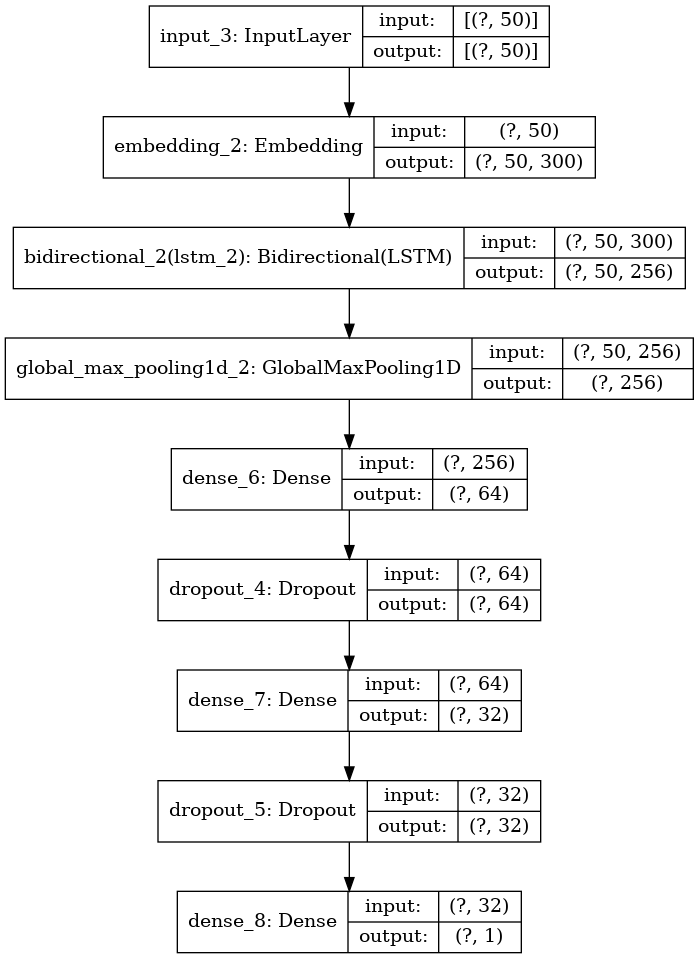

In [24]:
plot_model(model, show_shapes=True)

## Let's start the training of our model

In [25]:
BATCH_SIZE = 512
EPOCHS = 2

history = model.fit(
    train_data, target,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    # We are using randomly selected 20% sentences as validation data.
    validation_split=0.2
)

Train on 808618 samples, validate on 202155 samples
Epoch 1/2
808618/808618 [==============================] - 311s 385us/sample - loss: 0.5921 - accuracy: 0.6852 - val_loss: 0.5586 - val_accuracy: 0.7086
Epoch 2/2
808618/808618 [==============================] - 304s 376us/sample - loss: 0.5541 - accuracy: 0.7180 - val_loss: 0.5595 - val_accuracy: 0.7064


In [36]:
model.save('model.h5')

In [44]:
model = load_model('model.h5')

### Cool !!

Training is over.<br>
We can see validation accuracy above.<br>

### Let's test our model on some random input now.

In [45]:
sarcasm_data[sarcasm_data['label']==1].sample(20)

,label,comment
551867,1,gold plated
73141,1,assume xe gender
569260,1,black people cant racist
913388,1,yay memes
183671,1,borderline amazing dont believe
978307,1,reads thread scammers opens next thread asking trade beta keys looks user account created minutes ago post ever made nope hes totally legit
958965,1,fuck mean
500601,1,dads piss mg
237739,1,rebelling chinese province western imperialist pigdog
36793,1,well


In [46]:
sentence = "sun rises from the east"
sentence = normalize_document(sentence)
print(sentence)

sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen = MAX_LEN)
sentence

sun rises east


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0, 1584, 8911,  994]], dtype=int32)

We can see, how our sentence got converted into numbers.<br>

## We are doing padding to keep the final length same for every sentence no matter the sentence length.
## Our Neural network have learned to ignore 0 in the training itself.

In [47]:
# Make the prediction.
prediction = model.predict(sentence)
prediction[0][0]

0.3190041

In [48]:
print("So, it's saying sentence have probability of %.3f percent"%(prediction[0][0]*100))

So, it's saying sentence have probability of 31.900 percent


In [49]:
sentence = "Isn't it great that, your girlfriend dumped you?"
sentence = normalize_document(sentence)
print(sentence)

sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen = MAX_LEN)
sentence

isnt great girlfriend dumped


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   44,   49, 1612, 9174]], dtype=int32)

In [34]:
# Make the prediction.
prediction = model.predict(sentence)
prediction[0][0]

0.51583976

In [35]:
print("So, it's saying sentence have probability of %.3f percent"%(prediction[0][0]*100))

So, it's saying sentence have probability of 51.584 percent


## Sarcasm is a subjective matter.<br> One person can call a sentence sarcastic & another don't.
### So, results may be subjective. But our goal was to understand some basic concepts of NLP.

# Summary

* We saw what Tokenization is.
* We saw what word embedings are.
* We understood how a LSTM cell works in a nutshell.
* We cleaned the text data to use it in training
* We trained a deep learning model